In [14]:
import statsmodels.formula.api as smf
import pandas as pd

In [4]:
# Path to your .dta file
file_path = "/Users/danielseymour/Downloads/all3.dta"

# Load the .dta file into a DataFrame
df = pd.read_stata(file_path)

# Display the first few rows
df.head()

,sales_u,pctacv,data,price,date,region,AVC_dist,AVC_adver
0,302306,98,ch,1.047743,1991-01-05,ch,966.872375,9742.702148
1,287260,98,ch,1.030878,1991-01-12,ch,958.782227,9595.088867
2,307435,98,ch,1.029291,1991-01-19,ch,952.054138,9640.892578
3,294160,98,ch,1.053824,1991-01-26,ch,953.193054,9598.753906
4,300197,98,ch,1.038931,1991-02-02,ch,928.393372,9599.876953


In [3]:
df.describe()

,sales_u,pctacv,price,date,AVC_dist,AVC_adver
count,416.000000,416.000000,384.000000,416,416.000000,416.000000
mean,134445.644231,97.596154,1.095531,1991-12-31 12:00:00,932.106812,9389.291016
min,0.000000,77.000000,0.494999,1991-01-05 00:00:00,495.146240,5299.777832
25%,13750.750000,98.000000,1.065834,1991-07-04 06:00:00,955.757187,9441.390137
50%,104740.000000,99.000000,1.112700,1991-12-31 12:00:00,986.576508,9697.805664
75%,252974.250000,100.000000,1.138038,1992-06-28 18:00:00,997.274445,9844.130615
max,643756.000000,100.000000,1.216236,1992-12-26 00:00:00,999.985718,9999.769531
std,145279.183583,4.764364,0.071565,NaN,143.639221,887.489075


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   sales_u    416 non-null    int32         
 1   pctacv     416 non-null    int8          
 2   data       416 non-null    object        
 3   price      384 non-null    float32       
 4   date       416 non-null    datetime64[ns]
 5   region     416 non-null    category      
 6   AVC_dist   416 non-null    float32       
 7   AVC_adver  416 non-null    float32       
dtypes: category(1), datetime64[ns](1), float32(3), int32(1), int8(1), object(1)
memory usage: 14.1+ KB


Columns explained:  
- Sales in equivalent units (lbs) - quantity. 
- pctacv probably means Percentage of All Commodity Volume (ACV) (chatgpt). In consumer packaged goods (CPG) or scanner panel data, “ACV” (All Commodity Volume) refers to total retail sales volume for all products sold in the relevant retail universe, and “percentage ACV” (or “%ACV”) measures the fraction of that total volume in which a given product is carried. Values close to 100 usually mean the product is distributed in close to 100% of the store base (weighted by ACV), while lower values mean less coverage. So it is common to use pctacv as one of the demand shifters: broader distribution coverage tends to increase sales by making the product available in more places.  
- AVC_dist: Average Variable Cost of Distribution
- AVC_adver: Average Variable Cost of Advertising


Notes:  
- Data and region seem the same
- This is weekly data. 

In [7]:
# Convert both columns to strings before comparison
identical = df['data'].astype(str).equals(df['region'].astype(str))

print("Are the columns exactly the same?", identical)

Are the columns exactly the same? True


Question 1:  

Construct scatter-plots of  sales versus prices for Kraft in both regions (i.e. prices on the Y-axis, unit-sales on the X-axis). Repeat the exercise for Kraft. Is there evidence for a negatively sloped demand-curve in the data? In which of  the two region the OLS will give a more “correct” answer? 

In [10]:
df['region'].unique()

['ch', 'ck', 'jh', 'jk']
Categories (4, object): ['ch' < 'ck' < 'jh' < 'jk']

City or State Abbreviations:  
	•	ch → Chicago
	•	ck → Possibly Cincinnati or Kansas City
	•	jh → Jacksonville or Johnstown
	•	jk → Jersey City or Jackson

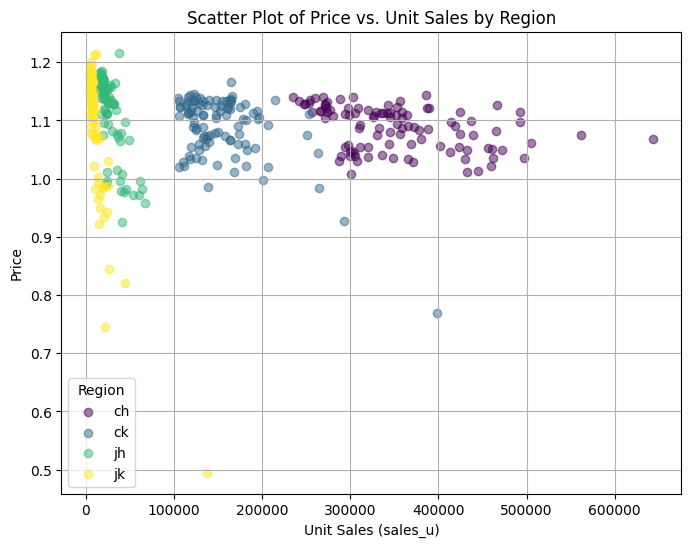

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Define unique regions
regions = df["region"].unique()

# Generate distinct colors for each region
colors = plt.cm.viridis(np.linspace(0, 1, len(regions)))  

# Create scatter plot for each region
plt.figure(figsize=(8, 6))
for i, region in enumerate(regions):
    subset = df[df["region"] == region]
    plt.scatter(subset["sales_u"], subset["price"], alpha=0.5, label=region, color=colors[i])

# Labels, legend, and title
plt.xlabel("Unit Sales (sales_u)")
plt.ylabel("Price")
plt.title("Scatter Plot of Price vs. Unit Sales by Region")
plt.legend(title="Region")
plt.grid(True)

# Show the plot
plt.show()

There is evidence of a negatively sloped demand-curve in the data for regions ch, jh. ck is ambigious. And for ch definitely not as the relationship is much more flat, there is no negative relationship betweenn price and sales.

Question 2:  
Fit the "multiplicative" demand model discussed in class one for each region. Estimate the model with OLS and then use an IV. 

What is the typical “multiplicative” demand model? 
It's when you assume constant elasticity of demand in market m (i.e. the region) in week t: 
$$
\ln(Q_{mt}) = x_{mt}\beta - \alpha \ln(p_{mt}) + \varepsilon_{mt}
$$

where Q_m and p_m are respectively total quantity and price, x_m are demand shifters, and ε_m is the unobservable component.

It's multiplicative because:

$$
Q_{mt} = \exp\bigl(x_{mt}\beta - \alpha\ln(p_{mt}) + \varepsilon_{mt}\bigr)
= \exp(x_{mt}\beta)\,[p_{mt}]^{-\alpha}\,\exp(\varepsilon_{mt}).
$$

We will first estimate by OLS and then by IV in Python. We will assume a stylized demand model of the form

Questions:
- Should I include a time subscript too here? Yes, as there could be variations in demand based on time
- What should the instrument be? As we are estimating demand, we want to use as an instrument a cost shifter. 
- Therefore, we can use the distribution costs, AVC_dis, to produce variation in price (relevance) while it is exogeneous to demand shocks. For estimating supply curves, advertising would be a good demand shifter.

In [15]:
df.columns

Index(['sales_u', 'pctacv', 'data', 'price', 'date', 'region', 'AVC_dist',
       'AVC_adver'],
      dtype='object')

In [13]:
# OLS

# Create new log columns
df['lnQ'] = np.log(df['sales_u'])
df['lnP'] = np.log(df['price'])
df['lnpctacv'] = np.log(df['pctacv'])
df['lnadver'] = np.log(df['AVC_adver'])

model_ols = smf.ols('lnQ ~ lnP + lnpctacv + lnadver', data=df).fit()
print(model_ols.summary())

# Unique list of regions
regions = df['region'].unique()

ols_results = {}

for reg in regions:
    # Subset data for this region
    df_region = df[df['region'] == reg]

    # Fit OLS: lnQ ~ lnP + lnX
    model_ols = smf.ols('lnQ ~ lnP + lnX', data=df_region).fit()

    # Store the result
    ols_results[reg] = model_ols

    print(f"\n=== OLS results for region: {reg} ===")
    print(model_ols.summary())

In [ ]:
# Using distribution costs as an IV

Question 3:  
Forecasting demand under a price change: Using your regression results from the multiplicative demand model, compute the % change in unit sales for a 10% increase in the price of  Kraft.

We can interpret
